##mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x5kbr9w_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x5kbr9w_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=43faa67c88448e0160efb36fb2470e92ca37b194cf99bde7feb1900c4c182172
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ctl2u4s/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-22 12:12:37--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os

sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns[:4]:
        m = ann['segmentation']
        if  not (m[0:50, :].any()) and not (m[-50:, :].any()) and not (m[:, 0:50].any()) and not  (m[:, -50:].any())  and (m[:, m.shape[1]//2-30:m.shape[1]//2+30].any()):
          color_mask = np.concatenate([np.random.random(3), [0.35]])
          img[m] = color_mask


    ax.imshow(img)

In [ ]:
def get_placenta_segments(image,plot_img=False):
    anns = mask_generator.generate(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    possibole_segment=[]
    for ann in sorted_anns[:4]:
        masd_dict = {"segmentation":ann['segmentation'],"area":ann['area']}
        m = ann['segmentation']
        if  not (m[0:50, :].any()) and not (m[-50:, :].any()) and not (m[:, 0:50].any())\
          and not  (m[:, -50:].any())  and (m[:, m.shape[1]//2-50:m.shape[1]//2+50].any()):
          possibole_segment.append(masd_dict)
    if len(possibole_segment)>0:
      final_mask = sorted(possibole_segment, key=lambda x: x['area'])[0]
      if plot_img:
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[final_mask["segmentation"]] = color_mask
        ax = plt.gca()
        ax.set_autoscale_on(False)
        ax.imshow(img)
      return final_mask["segmentation"]
    else:
      print("no segmentation for the placenta")

In [ ]:
def read_images_from_dict(directory):
  files = []
  for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        files.append(file_path)

  return files

In [ ]:
def display_segmant(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  axes[0].imshow(image)
  axes[0].axis('off')
  axes[0].set_title('Original Image')
  axes[1].imshow(image)
  seg = get_placenta_segments(image,True)
  print(type(seg))
  axes[1].axis('off')
  axes[1].set_title('Segmentation Result')
  plt.show()



In [ ]:
# images_paths = read_images_from_dict( directory = "/content/drive/MyDrive/placenta")
# image = cv2.imread(images_paths[0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# seg = get_placenta_segments(image,False)
# print(np.shape(seg))
# plt.imshow(seg)
# plt.show()


# read image

In [ ]:
images_paths = read_images_from_dict( directory = "/content/drive/MyDrive/placenta")
for img_path in images_paths:
  print(img_path)
  display_segmant(img_path)

## find convexity defects

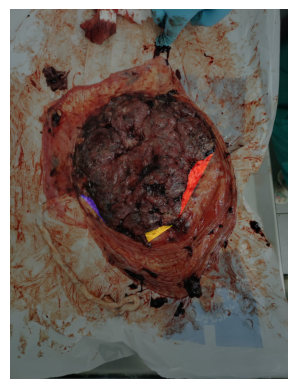

In [ ]:
import skimage as ski


def find_placenta_contours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)
    return img_contours, contours[0]

def find_convexity_defects(contour):
    hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull)
    return hull,defects


def plot_cnt(cnt, defects, img):
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(cnt[s][0])
        end = tuple(cnt[e][0])
        far = tuple(cnt[f][0])
        cv2.line(img, start, end, [0, 255, 0], 2)
        cv2.circle(img, far, 5, [0, 0, 255], -1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Final Image')
    plt.show()

def placenta_convexity_defects(image):
    segment = get_placenta_segments(image,False)
    background_color = [255, 255, 255]
    new_img = np.full_like(image, background_color)
    new_img[segment] = image[segment]
    segment = np.where(segment,1,0).astype("uint8")
    img_contours, placenta_contour= find_placenta_contours(segment)
    hull = cv2.convexHull(placenta_contour)
    hull_img = np.zeros_like(segment)
    hull_img= cv2.UMat(hull_img)
    cv2.drawContours(hull_img, [hull], 0, 1, thickness=cv2.FILLED)
    hull_img = cv2.UMat.get(hull_img)
    defects= hull_img-segment
    return defects

def order_connected_components(binary_image, original_image,k=3):
    labeled_image, count = ski.measure.label(binary_image, connectivity=2, return_num=True)
    properties = ski.measure.regionprops(labeled_image)
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    largest_labels = [region.label for region in sorted_regions[:k]]
    k_largest_cc_masks = [labeled_image == label for label in largest_labels]
    k_largest_cc_binary = np.any(k_largest_cc_masks, axis=0)
    k_largest_cc_binary, count = ski.measure.label(k_largest_cc_binary, connectivity=2, return_num=True)
    return k_largest_cc_binary

image_path="/content/drive/MyDrive/placenta/WhatsApp Image 2024-01-11 at 15.08.16.jpeg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
defect = placenta_convexity_defects(image)
k_largest_cc_binary = order_connected_components(defect,image)
colored_label_image = ski.color.label2rgb(k_largest_cc_binary, bg_label=0)
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colored_label_image, alpha=0.4)  # Adjust alpha for transparency
ax.axis("off")
plt.show()
